In [1]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow import keras
import keras_tuner
from keras.models import Model
from keras import layers
from keras import Input
from keras.layers import Dense, LeakyReLU, ReLU, Conv1D
from tensorflow.keras.utils import plot_model 


2024-04-08 01:09:17.314894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def run_tests(clf, name, X_train, y_train, X_test, y_test):
    """
        returns the test auroc
    """
    t0 = time.time()
    trained = clf.fit(X_train, y_train)
    t1 = time.time()
    pred1 = trained.predict(X_test)
    t2 = time.time()
    pa1 = trained.predict_proba(X_test)[:, 1]

    pred2 = trained.predict(X_train)
    pa2 = trained.predict_proba(X_train)[:, 1]

    print(pa1.shape, pa2.shape)

    # pred3 = trained.predict(X_val)
    # pa3 = trained.predict_proba(X_test)[:, 1]

    met1 = get_metrics(name + ' X_test', y_test, pred1, pa1)
    met2 = get_metrics(name + ' X_train', y_train, pred2, pa2)
    # met3 = get_metrics(name + ' X_val', y_val, pred3, pa3)

    print(f"({name}) Time to train", t1 - t0)
    print(f"({name}) Avg time to classify", (t2 - t1) / X_test.shape[0])
    print(f"({name}) (X_test) accuracy, precision, recall, specificity, AUROC", met1)
    print(f"({name}) (X_train) accuracy, precision, recall, specificity, AUROC", met2)

    return met1[4]
    # print(f"({name}) (X_val) accuracy, precision, recall, specificity, AUROC", met3)

In [3]:
def run_tests_ensamble(clfs, X_trains, y_train, X_tests, y_test):
    """
        returns the test auroc
    """
    pas1 = []
    pas2 = []
    for clf in clfs:
        for X_train, X_test in zip(X_trains, X_tests):
            # fit each classifier on each data set variation
            t = clf.fit(X_train, y_train)
            pas1.append(t.predict_proba(X_test)[:, 1])
            pas2.append(t.predict_proba(X_train)[:, 1])

    pa1 = np.mean(pas1, axis=0)
    pa2 = np.mean(pas2, axis=0)

    print(pa1.shape, pa2.shape)

    # pred3 = trained.predict(X_val)
    # pa3 = trained.predict_proba(X_test)[:, 1]

    # IMPORTANT JUST SETTING YPRED TO 0 RN CUZ I DONT CARE ABOUT IT, SHOULD FIX LATER
    met1 = get_metrics('ensamble' + ' X_test', y_test, [0]*y_test.shape[0], pa1)
    met2 = get_metrics('ensamble' + ' X_train', y_train, [0]*y_train.shape[0], pa2)
    # met3 = get_metrics('ensamble' + ' X_val', y_val, pred3, pa3)

    print(f"({'ensamble'}) (X_test) accuracy, precision, recall, specificity, AUROC", met1)
    print(f"({'ensamble'}) (X_train) accuracy, precision, recall, specificity, AUROC", met2)

    return met1[4]
    # print(f"({'ensamble'}) (X_val) accuracy, precision, recall, specificity, AUROC", met3)

In [4]:
def get_metrics(name, y_test, y_pred, proba):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fn + fp)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    specificity = tn / (tn+fp)
    roc_auc = roc_auc_score(y_test, proba)
    fpr, tpr, thresholds = roc_curve(y_test, proba, pos_label=1)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(name)
    plt.show()

    return accuracy, precision, recall, specificity, roc_auc

In [5]:
def prep_demo_data(y_train, y_test):
    X = pd.read_csv('train/train_demos.csv')
    X = X.set_index('patient_id')
    cat = ['gender', 'insurance', 'marital_status', 'ethnicity']
    # ONE HOT
    enc = OneHotEncoder()
    X_encoded = enc.fit_transform(X[cat])
    X_encoded = pd.DataFrame.sparse.from_spmatrix(X_encoded)
    X_encoded.index = X.index

    # LABEL
    # encoder = LabelEncoder()
    # X_encoded = X.copy()
    # for var in cat:
    #     X_encoded[var] = encoder.fit_transform(X_encoded[var])

    
    X = pd.concat([X.drop(cat, axis=1), X_encoded], axis=1)
    X['admittime'] = X.apply(lambda x: time.mktime(pd.Timestamp(x['admittime']).timetuple()), axis=1)
    X['admittime'] = X['admittime'] - X['admittime'].min()

    X_train = split(X, y_train.index)
    X_test = split(X, y_test.index)

    scaler = StandardScaler()
    scaler.fit(X_train[['age', 'admittime']])
    X_train[['age', 'admittime']] = scaler.transform(X_train[['age', 'admittime']])
    X_test[['age', 'admittime']] = scaler.transform(X_test[['age', 'admittime']])

    X_train.columns = X_train.columns.astype('str')
    X_test.columns = X_test.columns.astype('str')
    
    return X_train, X_test

In [6]:
def prep_signs_data(y_train, y_test):
    # CURRENTLY DROPS TIME COL
    signs = pd.read_csv('train/train_signs.csv')
    signs['charttime'] = pd.to_datetime(signs['charttime'])
    # maybe drop time??
    aggs = signs.drop(columns=['charttime']).groupby('patient_id').agg(['mean', 'min', 'max', 'first', 'last'])

    X_train = split(aggs, y_train.index)
    X_test = split(aggs, y_test.index)

    scaler = StandardScaler()
    features = X_train.columns
    id = X_train.index
    id_test = X_test.index

    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    X_train.columns = ['_'.join(x) for x in features]
    X_train.index = id
    X_test.columns = ['_'.join(x) for x in features]
    X_test.index = id_test

    # columns with more than 10% null values, drop these (10 columns, 2 metrics)
    drop_cols = X_train.columns[X_train.isna().sum() / X_train.shape[0] > .1] # should be just train set
    X_train = X_train.drop(columns=drop_cols)
    X_test = X_test.drop(columns=drop_cols)

    # is this the best way to do it??
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean()) # note train mean

    return X_train, X_test

In [7]:

def DAE_dimensionality_reducer(X_train,X_test,dim=30):
    """
        Reduces the dimension of X to whatever dim is given using Denoising Auto Encoder, this can lead to worse performance if dim is choosen poorly
    """
    # Specify how much noise to add
    level_of_noise=0.1

    # Add random noise based on sampling from Gaussian distribution
    X_train_noisy = X_train + level_of_noise * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
    X_test_noisy = X_test + level_of_noise * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
    
    input_size = X_train.shape[1]
    # Defines network layers encoder - middle - decoder, middle is the undercomplete layer that should be sampled 
    visible = Input(shape=(input_size,), name='Input-Layer') # Specify input shape
    e = Dense(units=input_size, name='Encoder-Layer')(visible)
    e = LeakyReLU(name='Encoder-Layer-Activation')(e)
    m = Dense(units=dim, activation='linear', kernel_regularizer=keras.regularizers.L1L2(l1=1e-1,l2=1e-1), name='Middle-Hidden-Layer')(e)
    d = Dense(units=input_size, name='Decoder-Layer')(m)
    d = LeakyReLU(name='Decoder-Layer-Activation')(d)
    output = Dense(units=input_size, activation='sigmoid', name='Output-Layer')(d)

    # Define denoising autoencoder model
    model = Model(inputs=visible, outputs=output, name='Denoising-Autoencoder-Model')

    # Compile denoising autoencoder model
    model.compile(optimizer='adam', loss='mse')


    # Fit the Denoising autoencoder model to reconstruct original images
    history = model.fit(X_train_noisy, X_train, epochs=40, batch_size=32, verbose=0, validation_split=0.2)

    # Plot a loss chart
    display(model.summary())
    fig, ax = plt.subplots(figsize=(16,9), dpi=300)
    plt.title(label='DAE Model loss by Epoch', loc='center')
    ax.plot(history.history['loss'], label='Training Data', color='black')
    ax.plot(history.history['val_loss'], label='Test Data', color='red')
    ax.set(xlabel='Epoch', ylabel='Loss')
    plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
    plt.legend()

    plt.show()
    
    # Once model is trained we sample the middle layer as that is the lower dimensional representation
    dimensionality_reducing_model = Model(inputs=model.input, outputs=[model.layers[3].output])
    X_train_reduced = dimensionality_reducing_model.predict(X_train)

    return pd.DataFrame(dimensionality_reducing_model.predict(X_train),index=X_train.index),  pd.DataFrame(dimensionality_reducing_model.predict(X_test),index=X_test.index)

In [8]:
def train_test(balance_train=False):
    # returns the train test split labels
    y = pd.read_csv('train/train_labels.csv')
    y = y.set_index('patient_id')
    y_train = y.sample(n=int(y.shape[0] * .8))
    y_test = y.drop(y_train.index)
    if balance_train:
        # RUN THIS CELL IF YOU WANT AN EVEN DATA CLASS BALANCE
        keep_ids = y_train[y_train['label'] == 0].sample(n=y_train['label'].sum()).index
        ys = y_train[y_train['label'] == 1].index
        y_train = y_train.loc[[*keep_ids, *ys]]
    return y_train, y_test

In [9]:
def split(X, index):
    return X.loc[index]

In [10]:
def prep_radiology_data(y_train, y_test):
    df = pd.read_csv('train/train_radiology.csv')
    df = df.groupby('patient_id').agg({'text': ['sum']})

    
    X_train = split(df, y_train.index)
    X_test = split(df, y_test.index)    
    
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, max_features=100, stop_words="english")
    vec_train = vectorizer.fit_transform(X_train['text']['sum'])
    vec_test = vectorizer.transform(X_test['text']['sum'])
    X_train = pd.concat([X_train.drop(columns=['text']), pd.DataFrame(vec_train.toarray(), index=y_train.index)], axis=1)
    X_test = pd.concat([X_test.drop(columns=['text']), pd.DataFrame(vec_test.toarray(), index=y_test.index)], axis=1)
    
    # X_train[('charttime','first')] = pd.to_datetime(X_train[('charttime','first')])
    # X_train[('charttime','last')] = pd.to_datetime(X_train[('charttime','last')])
    # X_test[('charttime','first')] = pd.to_datetime(X_test[('charttime','first')])
    # X_test[('charttime','last')] = pd.to_datetime(X_test[('charttime','last')])

    scaler = StandardScaler()
    features = X_train.columns
    id = X_train.index
    id_test = X_test.index

    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    X_train.columns = features
    X_train.index = id
    X_test.columns = features
    X_test.index = id_test

    return X_train, X_test

(2046, 140) (2046, 100) (2046, 20)
(2046, 260)


/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

(2742,) (2046,)


/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

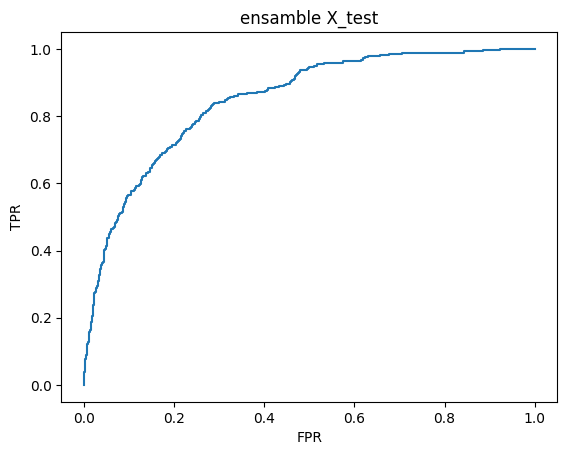

/var/folders/qd/q50f4_v16n7fp25tfl78t3ph0000gn/T/ipykernel_60235/1136690420.py:4: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+fp)


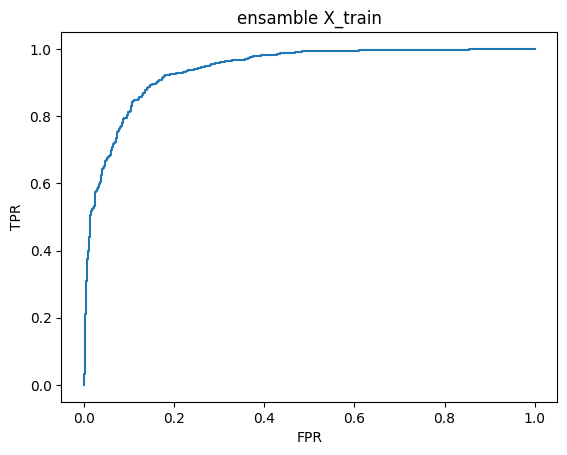

(ensamble) (X_test) accuracy, precision, recall, specificity, AUROC (0.8975200583515682, nan, 0.0, 1.0, 0.8479569541068426)
(ensamble) (X_train) accuracy, precision, recall, specificity, AUROC (0.5, nan, 0.0, 1.0, 0.9394570050137169)


0.8479569541068426

In [207]:
y_train, y_test = train_test(balance_train=True)

sign_train, sign_test = prep_signs_data(y_train, y_test)
rad_train, rad_test = prep_radiology_data(y_train, y_test)
demo_train, demo_test = prep_demo_data(y_train, y_test)
print(sign_train.shape,rad_train.shape,demo_train.shape)
# rad_train, rad_test = DAE_dimensionality_reducer(rad_train,rad_test,dim=100)

X_train = pd.concat([sign_train, rad_train, demo_train], axis=1)
X_test = pd.concat([sign_test, rad_test, demo_test], axis=1)
print(X_train.shape)
# X_train, X_test = DAE_dimensionality_reducer(rad_train,rad_test,dim=100)
# Reduces the dimension of X while preserving as much information as possible as determined by the DAE
# X_train, X_test = DAE_dimensionality_reducer(X_train,X_test,dim=25)

X_train.columns = X_train.columns.astype('str')
X_test.columns = X_test.columns.astype('str')


# svm
svc = svm.SVC(kernel='rbf', probability=True)
logreg = LogisticRegression()
# run_tests(svc, 'SVC', X_train, y_train, X_test, y_test)
# run_tests(logreg, 'Logistic', X_train, y_train, X_test, y_test)

run_tests_ensamble([svc, logreg], [sign_train, rad_train, demo_train], y_train, [sign_test, rad_test, demo_test], y_test)

## NN TIME

In [11]:
y_train, y_test = train_test(balance_train=False)

sign_train, sign_test = prep_signs_data(y_train, y_test)
rad_train, rad_test = prep_radiology_data(y_train, y_test)
demo_train, demo_test = prep_demo_data(y_train, y_test)
print(sign_train.shape,rad_train.shape,demo_train.shape)
# rad_train, rad_test = DAE_dimensionality_reducer(rad_train,rad_test,dim=100)

X_train = pd.concat([sign_train, rad_train, demo_train], axis=1)
X_test = pd.concat([sign_test, rad_test, demo_test], axis=1)

X_train.columns = X_train.columns.astype('str')
X_test.columns = X_test.columns.astype('str')

(10966, 140) (10966, 100) (10966, 20)


In [12]:
input_size = X_train.shape[1]

model = keras.Sequential([
        layers.Dense(input_size, activation="tanh", name='Input-Layer'),
        layers.Dense(units=100,activation="tanh", kernel_regularizer=keras.regularizers.L1L2(l1=1e-2, l2=1e-2),name='Hidden-Layer-1'),
        # layers.Dense(units=100, activation='tanh',kernel_regularizer=keras.regularizers.L1L2(l1=1e-3, l2=1e-2), name='Hidden-Layer-2'),
        layers.Dense(units=1,activation='sigmoid',name='Output')
])


# Compile denoising autoencoder model
model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.AUC])


In [138]:
# Function for running a random search over a keras model, acts as a first pass for model design
auc = keras.metrics.AUC()
loss = keras.losses.BinaryCrossentropy()
def build_random_model(hp):
    
    model = keras.Sequential()
    j = 0
    for i in range(1, hp.Int("num_layers", 2, 4)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=2, max_value=16, step=1),
                # kernel_regularizer=keras.regularizers.L1L2(hp.Choice('l1',[1e-2,1e-3,1e-4,1e-5, 0.0]), hp.Choice('l2',[1e-2,1e-3,1e-4,1e-5,0.0])),
                activation="relu",
                name='Hidden-Layer-'+str(i))
            )
        
        # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
        model.add(keras.layers.Dropout(0.5)) 
    
    
    model.add(keras.layers.Dense(1, activation='sigmoid',name='Output'))
    
    model.compile(optimizer='adam', loss=loss,metrics=[auc])
    return model

In [149]:
tuner = keras_tuner.RandomSearch(
    build_random_model,
    objective=keras_tuner.Objective('val_loss','min'),
    max_trials=300,
    overwrite=True,
    directory="random_search",
    project_name="v1"
)

tuner.search(X_train, y_train, epochs=15, validation_split=0.1)


Trial 72 Complete [00h 00m 07s]
val_loss: 0.24052643775939941

Best val_loss So Far: 0.21679092943668365
Total elapsed time: 00h 08m 00s

Search: Running Trial #73

Value             |Best Value So Far |Hyperparameter
4                 |2                 |num_layers
14                |10                |units_1
4                 |13                |units_2
2                 |9                 |units_3

Epoch 1/15
263/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.5540 - loss: 0.9062

KeyboardInterrupt: 

In [150]:
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

/Users/benware/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden-Layer-1 (Dense)          │ (None, 10)             │         2,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621 (10.24 KB)

 Trainable params: 2,621 (10.24 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
X_train.shape

(10966, 260)

In [151]:

history = best_model.fit(X_train,y_train, epochs=40,validation_split=0.1)


Epoch 1/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc: 0.6002 - loss: 0.2223 - val_auc: 0.8636 - val_loss: 0.2201
Epoch 2/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - auc: 0.8556 - loss: 0.2265 - val_auc: 0.8651 - val_loss: 0.2193
Epoch 3/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - auc: 0.8656 - loss: 0.2208 - val_auc: 0.8631 - val_loss: 0.2192
Epoch 4/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - auc: 0.8716 - loss: 0.2210 - val_auc: 0.8655 - val_loss: 0.2175
Epoch 5/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - auc: 0.8706 - loss: 0.2182 - val_auc: 0.8596 - val_loss: 0.2209
Epoch 6/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - auc: 0.8779 - loss: 0.2134 - val_auc: 0.8577 - val_loss: 0.2243
Epoch 7/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - auc: 0.8738 - loss: 0.2173 - val_auc: 0.8605 - val_loss: 0.2253
Epoch 8/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.8673 - loss: 0.2201 - val_auc: 0.8612 - val_loss: 0.2238
Epoch 9/40
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 8

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden-Layer-1 (Dense)          │ (None, 10)             │         2,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,865 (30.73 KB)

 Trainable params: 2,621 (10.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,244 (20.49 KB)

None

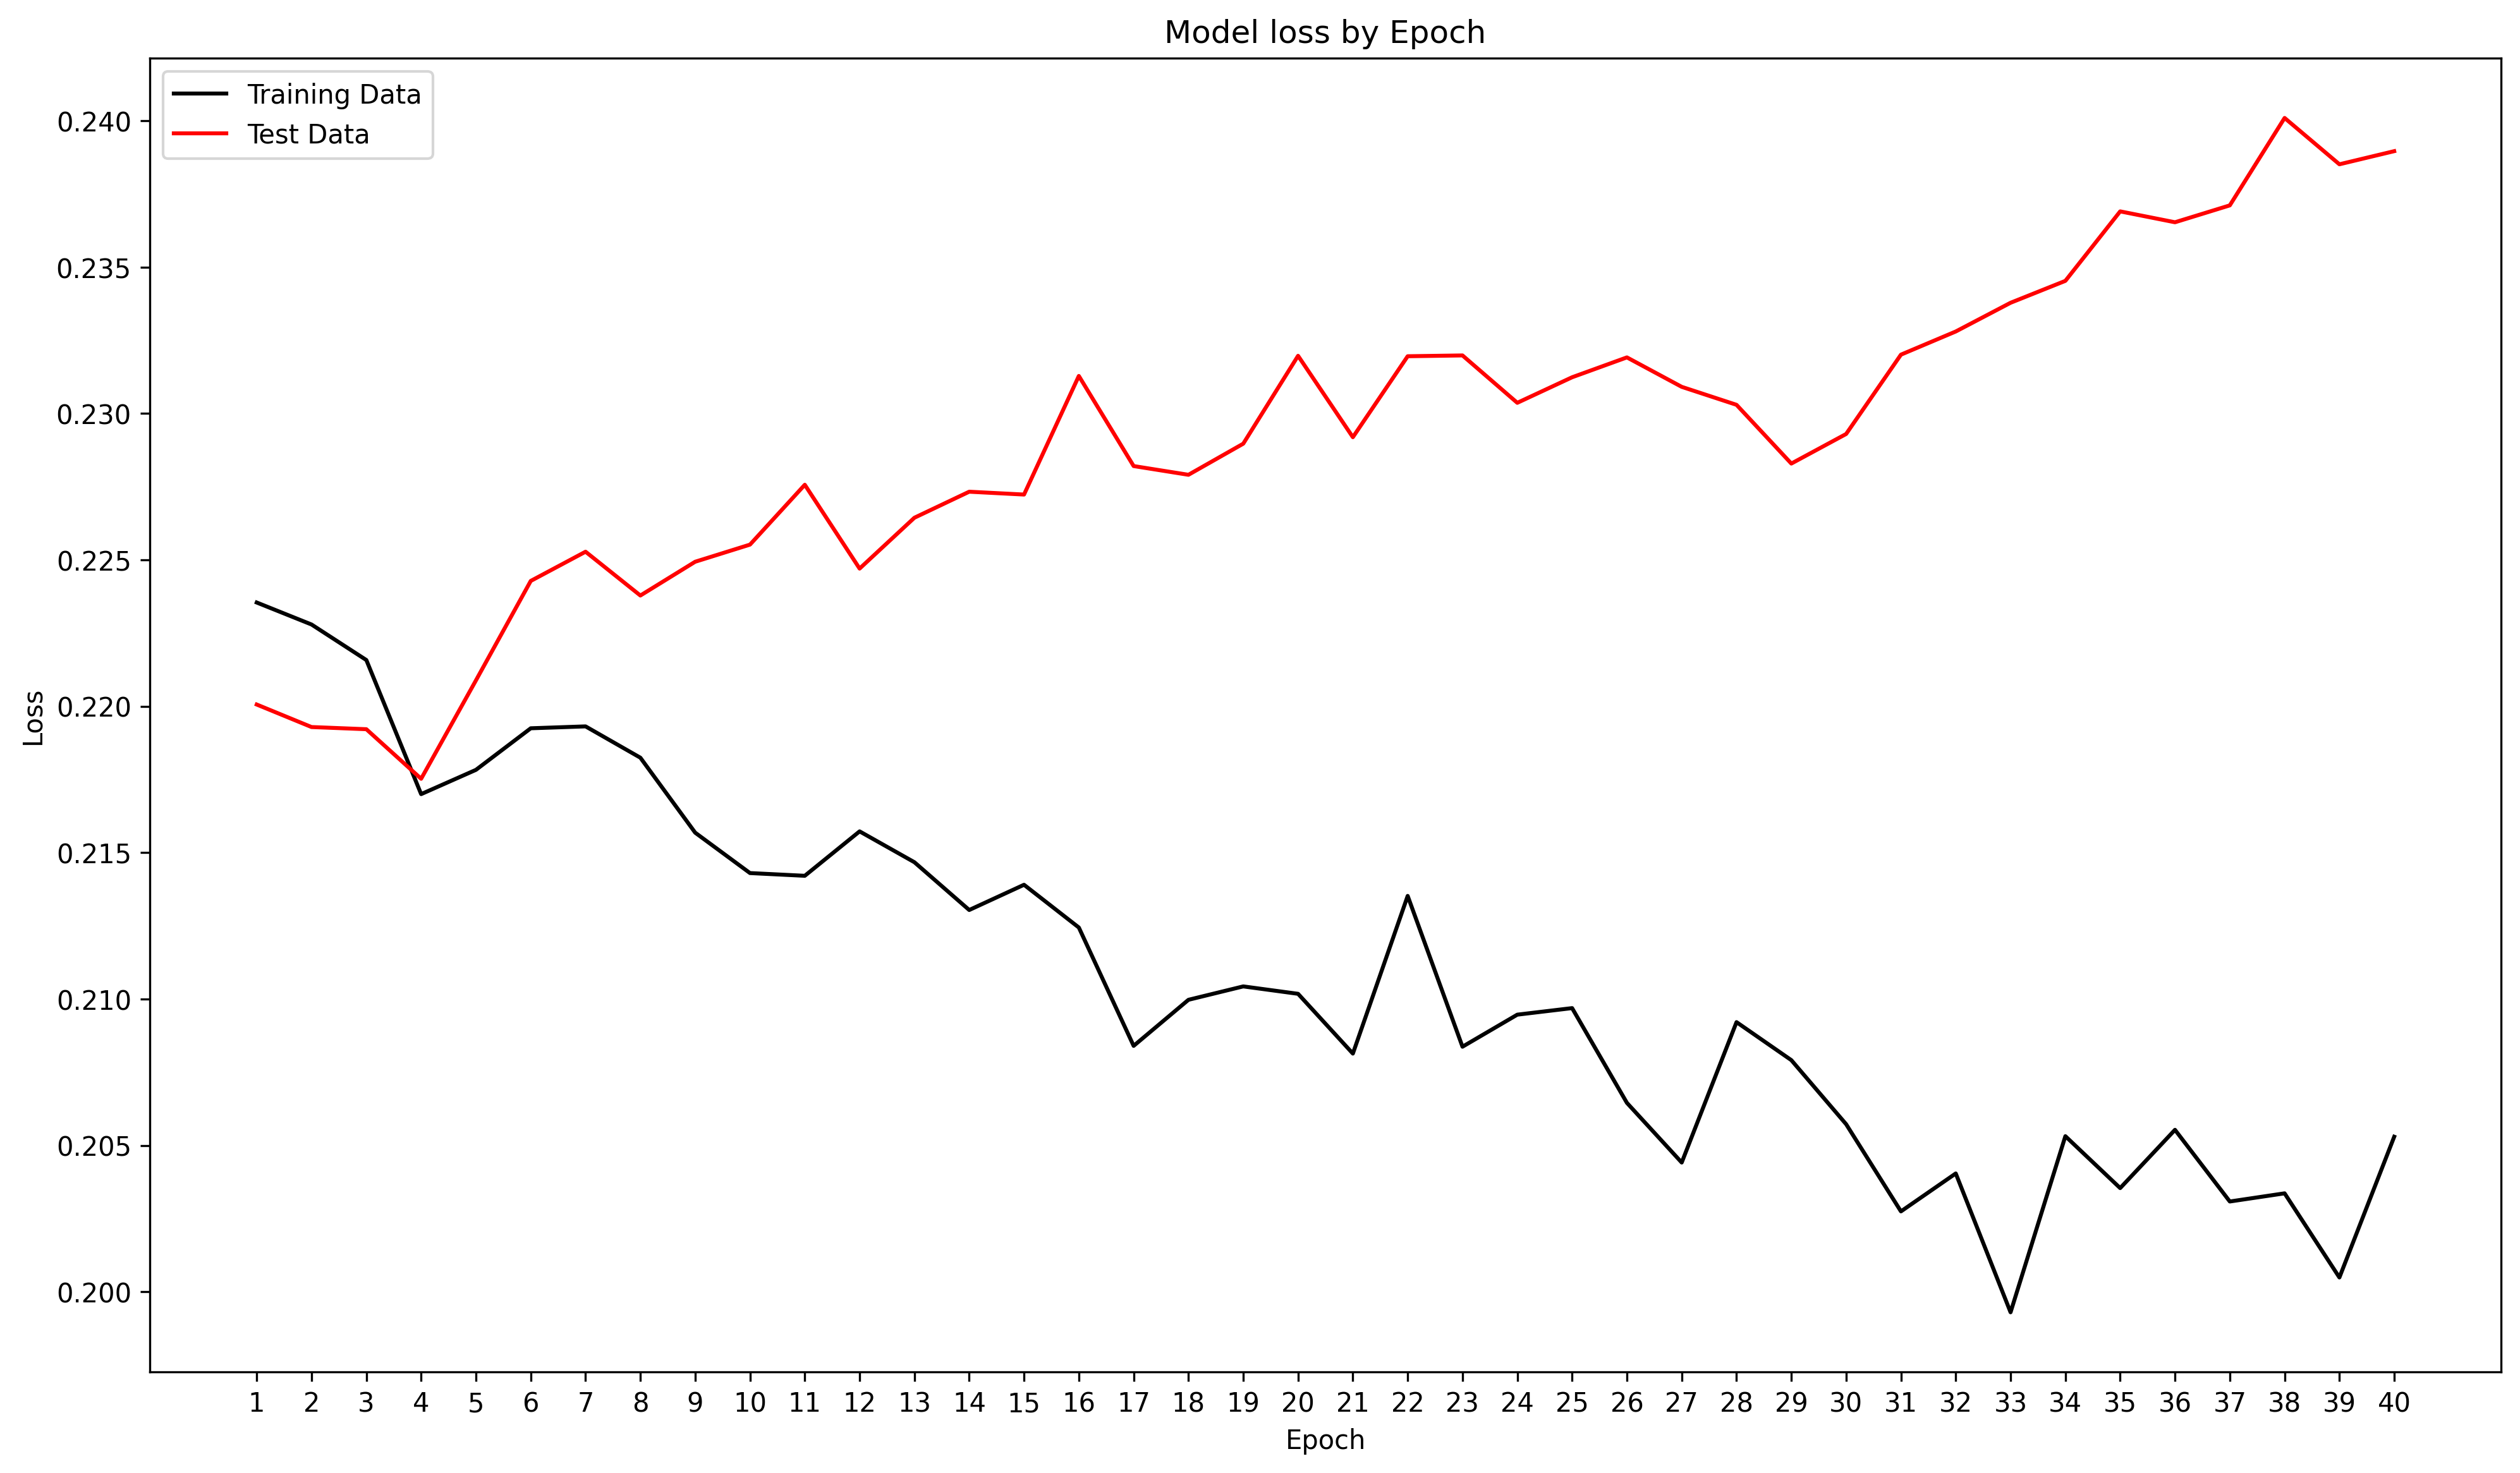

train
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - auc: 0.5215 - loss: 18.9321
prediction
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - auc: 0.5007 - loss: 18.9284


[18.935317993164062, 0.5112694501876831]

In [152]:
# Plot a loss chart
display(best_model.summary())
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model loss by Epoch', loc='center')
ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
plt.legend()

plt.show()
print("train")
model.evaluate(X_train, y_train)
print("prediction")
model.evaluate(X_test, y_test)


In [147]:
#L1L2 seems no good
# Want later layers to be smaller than earlier ones
# Not sure about optimal dropout

In [49]:
# Second pass grid search centered on best params found in random search
auc = keras.metrics.AUC()
loss = keras.losses.BinaryCrossentropy()
best_params = tuner.get_best_hyperparameters()[0].values
print(best_params)
def build_grid_model(hp):
    
    model = keras.Sequential()
    
    for i in range(1, best_params['num_layers']+1):
        units = "units_" + str(i)
        name = 'Hidden-Layer-'+str(i)
        model.add(
            keras.layers.Dense(
                units=hp.Int(units, min_value=32, max_value=1024, step=32, default=best_params[units]),
                kernel_regularizer=keras.regularizers.L1L2(l1=1e-4,l2=1e-3),
                activation="relu",
                name=name,
            ))
        
        # Add dropout to all layers except last one
        if i != 5:
            model.add(keras.layers.Dropout(0.5))
    
    
    model.add(keras.layers.Dense(1, activation='sigmoid',name='Output'))
    
    model.compile(optimizer='adam', loss=loss,metrics=[auc])
    return model

{'units_1': 512, 'dropout_1': 0.1, 'units_2': 288, 'dropout_2': 0.2, 'units_3': 320, 'dropout_3': 0.1, 'units_4': 96, 'dropout_4': 0.1, 'units_5': 128, 'dropout_5': 0.2}


In [52]:
# Tune binary cross entropy directly as that is the loss function in the model and training AUC may lead to overfitting
tuner = keras_tuner.GridSearch(
    build_grid_model,
    objective=keras_tuner.Objective('val_'+loss.name,'min'),
    max_trials=300,
    overwrite=True,
    directory="grid_search",
    project_name="v1"
)

tuner.search(X_train, y_train, epochs=15, validation_split=0.2)

KeyError: 'num_layers'

In [24]:
# Random search result :0.873 val AUC
# {'num_layers': 5, 'units_1': 512, 'l1': 0.0001, 'l2': 0.001, 'dropout_1': 0.1, 'units_2': 288, 'dropout_2': 0.2, 'units_3': 320, 'dropout_3': 0.1, 'units_4': 96, 'dropout_4': 0.1, 'units_5': 128, 'dropout_5': 0.0}
best_params = tuner.get_best_hyperparameters()

for params in best_params:
    print(params.values)

{'num_layers': 5, 'units_1': 512, 'l1': 0.0001, 'l2': 0.001, 'dropout_1': 0.1, 'units_2': 288, 'dropout_2': 0.2, 'units_3': 320, 'dropout_3': 0.1, 'units_4': 96, 'dropout_4': 0.1, 'units_5': 128, 'dropout_5': 0.0}


In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=1, validation_split=0.2)

# Plot a loss chart
display(model.summary())
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model loss by Epoch', loc='center')
ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
plt.legend()

plt.show()
print("train")
model.evaluate(X_train, y_train)
print("prediction")
model.evaluate(X_test, y_test)
